## Meas/Coords Validation with Astropy

This goal of this Notebook is to show that real data mapped on `Measure` classes can be transformed in Astropy instances in a transparent way.

We proceed with data mapped on individual `Measure` objects in order to avoid bias possibly introduced by some host model.

This workflow validates the [Measure](https://github.com/ivoa/modelinstanceinvot-code) model (and its coordinates(https://github.com/ivoa-std/CoordinateDM)) in the extand of the the implemented classes.


### Test Case

The VOtable has been queried from tme ESAC archive (https://gea.esac.esa.int/tap-server/tap) with the following query:
```
SELECT TOP 100 gaiadr2.gaia_source.designation, gaiadr2.gaia_source.ra, gaiadr2.gaia_source.ra_error ,
               gaiadr2.gaia_source."dec", gaiadr2.gaia_source.dec_error, gaiadr2.gaia_source.parallax , 
               gaiadr2.gaia_source.parallax_error, gaiadr2.gaia_source.pmra, 
               gaiadr2.gaia_source.pmra_error, gaiadr2.gaia_source.pmdec, 
               gaiadr2.gaia_source.pmdec_error,gaiadr2.gaia_source.radial_velocity, 
               gaiadr2.gaia_source.radial_velocity_error
 FROM  gaiadr2.gaia_source
 WHERE ( CONTAINS(POINT('ICRS', ra, "dec"), 
         CIRCLE('ICRS', 162.328814, -53.319466, 0.016666666666666666)) = 1 )
```

We select positions, parallax, radial velocity and proper motions around `luhman 16`. 

The goal of the script is to show how we can build complex Astropy SkyCoord object in a transparent way by using the `Meas/Coords` mapping. 
The parallax is given to Astropy to build the 3rd coordinate dimension. 
There no data checking, for each row, all mapped STC components are built and given to the SkyCoord builder which does its best.
    
- We are using the annotation [syntax](https://github.com/ivoa-std/ModelInstanceInVot) that has been designed after the 2021 workshop.
- The Python code used for this notebook is being [developped](https://github.com/ivoa/modelinstanceinvot-code) to design qnd validate the processing of model annotation.
- This notebook does not pretend to have any scientific value, it is juste a validation case for the mapping syntax 


### Package Init
- Import packages

In [1]:
import sys
import os
import logging
import matplotlib
import mplcursors
import matplotlib.pyplot as plt 
import numpy as np
from astropy.io.votable import parse
from astropy.visualization import astropy_mpl_style

## Init Path
- lock the base dir against multiple runs
- Set PYTHONPATH
- Import local packages

In [2]:
base_dir = os.path.realpath(os.path.join(os.getcwd(), ".."))
data_path = os.path.join(base_dir, "mivot_code", "examples", "data/")

print(os.getcwd())
print(base_dir)
sys.path.append(os.path.realpath(base_dir))

from mivot_code.client.xml_interpreter.model_viewer import ModelViewer
from mivot_code.utils.quantity_converter import QuantityConverter

plt.style.use(astropy_mpl_style)
matplotlib.font_manager: logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)

print(data_path)

/Users/laurentmichel/Documents/seafile/Seafile/workspaces/git/modelinstanceinvot-code/jupyter
/Users/laurentmichel/Documents/seafile/Seafile/workspaces/git/modelinstanceinvot-code
   INFO - [__init__.py:  7 -   <module>()] - utils package initialized
   INFO - [__init__.py: 16 -   <module>()] - client package intialized
   INFO - [__init__.py: 14 -   <module>()] - translator package intialized
/Users/laurentmichel/Documents/seafile/Seafile/workspaces/git/modelinstanceinvot-code/mivot_code/examples/data/


## VOTable parsing
The VOTable is parsed by Astropy as usual

In [3]:
votable = parse(os.path.join(data_path, "gaia_luhman16_astropy.xml"))

## Building the Model Viewer
The model viewer wrapps the VOTable data iterator to provide model views of the current data raw
The model viewer supports 4 serializations:
- XML (hidden used)
- JSON 
- STC components (hidden used)
- Astropy SkyCoord (used here)

In the future, the resource selection should be handled by the either Astropy or PyVO, but meanwhile this is not implemented, the job is done by hand. 
We assume that the 1st resource is annotated.


- We assume we will work on data of the `Results` table
- We do not look for complex objects that could be located in some other tables or in the GLOBALS block


In [4]:
for resource in votable.resources:
    mviewer = ModelViewer(resource, votable_path=os.path.join(data_path, "gaia_luhman16_astropy.xml"))
    mviewer.connect_table('Results')
    break;

   INFO - [model_viewer.py:402 - _extract_mapping_block()] - extract vodml block from /Users/laurentmichel/Documents/seafile/Seafile/workspaces/git/modelinstanceinvot-code/mivot_code/examples/data/gaia_luhman16_astropy.xml
   INFO - [annotation_seeker.py: 38 -   __init__()] - Found GLOBALS
   INFO - [annotation_seeker.py: 46 -   __init__()] - Found TEMPLATES Results
   INFO - [model_viewer.py:416 - _extract_mapping_block()] - VODML found
  DEBUG - [model_viewer.py:203 - connect_table()] - table Results found in VOTable
  DEBUG - [model_viewer.py:208 - connect_table()] - TEMPLATES Results found 


## Using Data Model Views
The model viewer iterate over the data row by using the Astropy parser. The last read row is stored internally to be available for the viewer processing.

In the current the example, we let the astropy wrapper building a SkyCoord instance with the mapped data.
if the instanciation process fails due to a mapping error, a None insatnce is returned
Parallax are transformed as distances by Astropy to build 3D sky positions and proper motions are given by tooltips.


In [5]:
# init data to be plotted
tooltips = []
ras = []
decs = []
dist = []
# Necessary to execute the cell several times
mviewer.rewind()

while True:
    # get a data row (numpy)
    row = mviewer.get_next_row() 
    if row is None:
        break  
    # get the astropy SkyCoord object for that row
    position = mviewer.get_astropy_sky_coord() 
    # Should never happend
    if position is None:
        continue
    # stores the parameters to be plotted  
    # Ignore not set-distances and limit the distance range for the plot readability      
    if not np.isnan(position.distance.value) and position.distance.value < 5000.0:
        ras.append(position.ra.value)    
        decs.append(position.dec.value)   
        dist.append(position.distance.value)   
        tooltips.append(f"Proper Motion ra:{position.pm_ra_cosdec:.2f} \ndec:{position.pm_dec:.2f} ")

## Matplotlib setup

Activate dynamic plots to make the tooltips working.

In [6]:
%matplotlib widget

  DEBUG - [pyplot.py:280 - switch_backend()] - Loaded backend module://ipympl.backend_nbagg version unknown.


## Lets plot

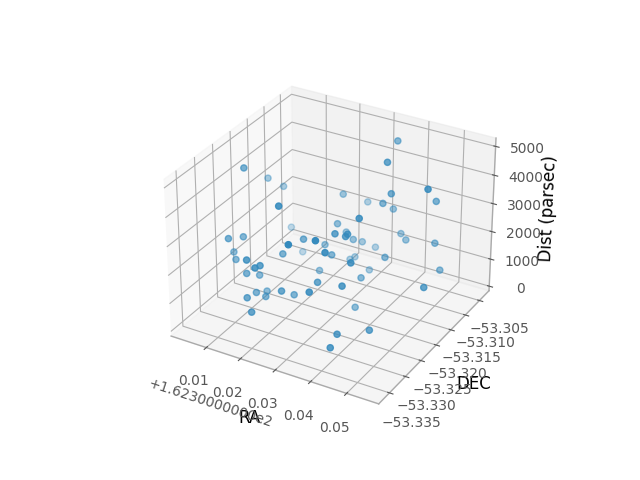

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ras, decs, dist)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_zlabel('Dist (parsec)')
mplcursors.cursor(hover=True).connect("add", lambda sel: sel.annotation.set_text(tooltips[sel.index]))
plt.show()